In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load in 

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
import time

#print(tf.__version__)
# Input data files are available in the "/home/opc/formule1" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))

['f1_info.db', 'circuits.csv', 'constructor_results.csv', 'constructors.csv', 'constructor_standings.csv', 'drivers.csv', 'driver_standings.csv', 'lap_times.csv', 'last_race.csv', 'pit_stops.csv', 'qualifying.csv', 'races.csv', 'results.csv', 'seasons.csv', 'status.csv']


In [2]:
#----------------------------Read in Data------------------------------------------------------------
#Read in the race results data
results_raw = pd.read_csv('./data/results.csv', na_values = "?", comment='\t')

#Read in the races data
races_raw = pd.read_csv('./data/races.csv', na_values = "?", comment='\t')

#Read in the last races of season data
last_race_raw = pd.read_csv('./data/last_race.csv', na_values = "?", comment='\t')
last_race_raw.rename(columns={'Year':'year', 'Race ID': 'raceId'}, inplace=True)

#Read in the list of driver standings
driver_standings = pd.read_csv('./data/driver_standings.csv')


In [3]:
#------------------------------------------------------------------------------------------------------

#Remove year column from last race data
#last_race_raw = last_race_raw.drop(columns='Year')



In [4]:
#-------------------- Filtering Races Data ---------------------
#Remove uneccesary race columns
races_raw = races_raw.drop(columns=['date', 'time', 'url'])

#Remove all races that aren't the first of the season
first_race_index = races_raw[races_raw['round'] != 1].index
races_raw = races_raw.drop(first_race_index)

#Keep only first round races from 2000 to 2017
race_year_index_low = races_raw[races_raw['year'] < 2000].index
race_year_index_high = races_raw[races_raw['year'] > 2017].index
races_raw = races_raw.drop(index=race_year_index_low) 
races_raw = races_raw.drop(index=race_year_index_high)
races_raw = races_raw.sort_values(by=['year'])


#Remove uneccesary race columns
races_filtered = races_raw.drop(columns=['round', 'circuitId', 'name'])
#print(races_filtered.to_string())
#----------------------------------------------------------------------------------


In [5]:
#---------------------Filtering Results Data--------------------------------------
#Clean the Raw results data to only include columns that we want
#Get a list of the first races ID's and filter the results table to only those races
firstraceId_list = races_filtered['raceId'].tolist()
raceId_filter = results_raw['raceId'].isin(firstraceId_list)
results_filtered = results_raw[raceId_filter]

#Dropping columns that we aren't interested in
results_filtered = results_filtered.drop(columns=['number','position', 'positionText', 'points','time', 'statusId'])

#print(results_raw.isna().sum())

results_filtered = pd.merge(results_filtered, races_filtered, on='raceId')
drivers_start_list = results_filtered['driverId'].unique()
print(results_filtered.count())

resultId           388
raceId             388
driverId           388
constructorId      388
grid               388
positionOrder      388
laps               388
milliseconds       388
fastestLap         388
rank               388
fastestLapTime     388
fastestLapSpeed    388
year               388
dtype: int64


In [6]:
#--------------------------Finding the standing for each driver as of the last race of the year-------------------------------

#Get a list of the IDs of the last races of every year
lastraceId_list = last_race_raw['raceId'].tolist()
#print(lastraceId_list)

print(results_filtered.count())
#print(standings_filtered.count())
#Filter the drivers standings to only include the last races of the year
lastRaceId_filter = driver_standings['raceId'].isin(lastraceId_list)
standings_filtered = driver_standings[lastRaceId_filter]
#Drop standings columns that we don't want
standings_filtered = standings_filtered.drop(columns=['driverStandingsId', 'positionText', 'points', 'wins'])
#Sort the standings by raceId and by driverId
standings_filtered = standings_filtered.sort_values(["raceId","driverId"])
standings_filtered = pd.merge(standings_filtered, last_race_raw, on='raceId')
standings_filtered.rename(columns={'position':'seasonEndPos'}, inplace=True)
drivers_end_list = standings_filtered['driverId'].unique()


resultId           388
raceId             388
driverId           388
constructorId      388
grid               388
positionOrder      388
laps               388
milliseconds       388
fastestLap         388
rank               388
fastestLapTime     388
fastestLapSpeed    388
year               388
dtype: int64


In [7]:
#for driver in drivers_start_list:
#    standings_filtered = standings_filtered[standings_filtered.driverId != driver]

#print(standings_filtered.count())
#print(standings_filtered.to_string())
#print(results_filtered.to_string())
#In the last race CSV change the race ID to the first race of the season so that we can identify it in the results CSV. 
#All of this spaghet is to make sure that we can merge the last place standings with the results page. 

#print(results_filtered.to_string())
#driver_standings.tail()

#Clean the driver standings dataset
#driver_standings.isna().sum()
#driver_standings.drop(columns = ['positionText','wins'])

full_results = pd.merge(results_filtered, standings_filtered, how='inner', on=['driverId', 'year'])
full_results = full_results.drop(columns=['resultId', 'raceId_x', 'driverId', 'constructorId', 'milliseconds', 'fastestLap', 'fastestLapSpeed', 'fastestLapTime','rank', 'year', 'raceId_y'])
dataset = full_results.dropna()

"""
#Change the fastest lap time to miliseconds
for index, row in dataset.iterrows():
    timestring = row['fastestLapTime']
    pt = datetime.datetime.strptime(timestring,'%M:%S.%f')
    total_miliseconds = pt.microsecond/1000000 + pt.second + pt.minute*60
    dataset.at[index,'fastestLapTime'] = total_miliseconds



dataset["fastestLapTime"] = pd.to_numeric(dataset["fastestLapTime"])
"""


'\n#Change the fastest lap time to miliseconds\nfor index, row in dataset.iterrows():\n    timestring = row[\'fastestLapTime\']\n    pt = datetime.datetime.strptime(timestring,\'%M:%S.%f\')\n    total_miliseconds = pt.microsecond/1000000 + pt.second + pt.minute*60\n    dataset.at[index,\'fastestLapTime\'] = total_miliseconds\n\n\n\ndataset["fastestLapTime"] = pd.to_numeric(dataset["fastestLapTime"])\n'

               count       mean        std  min    25%   50%   75%   max
grid           310.0  11.022581   6.496910  0.0   5.25  11.0  17.0  24.0
positionOrder  310.0  11.519355   6.455068  1.0   6.00  12.0  17.0  24.0
laps           310.0  42.670968  20.762522  0.0  27.25  56.0  57.0  58.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


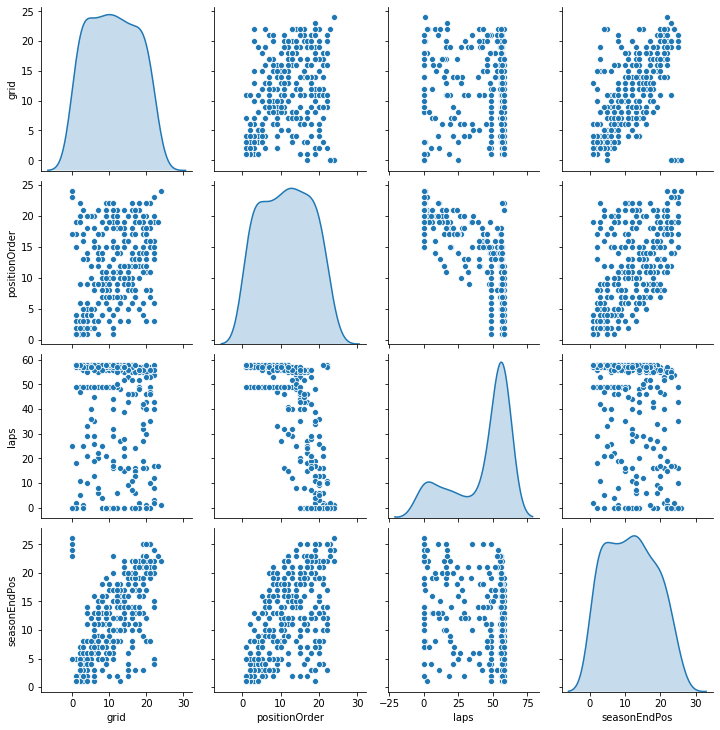

In [8]:
#Begin Regression
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["grid", "positionOrder", "laps", "seasonEndPos"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("seasonEndPos")
train_stats = train_stats.transpose()
print(train_stats)

#Split Features from labels
train_labels = train_dataset.pop('seasonEndPos')
test_labels = test_dataset.pop('seasonEndPos')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#Build the model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

model.summary()

In [9]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
#print(example_result)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [10]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,9.585863,2.378784,9.585863,22.141384,3.651828,22.141384,995
996,9.672740,2.420939,9.672740,21.546534,3.569075,21.546534,996
997,9.538030,2.384584,9.538030,21.711020,3.572707,21.711020,997
998,9.523499,2.389196,9.523499,21.771973,3.610696,21.771973,998
999,9.687343,2.436661,9.687343,21.752731,3.589390,21.752731,999


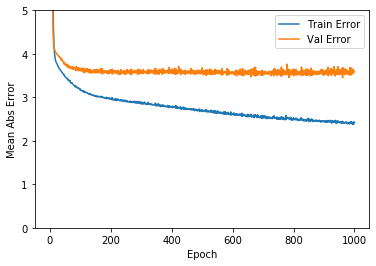

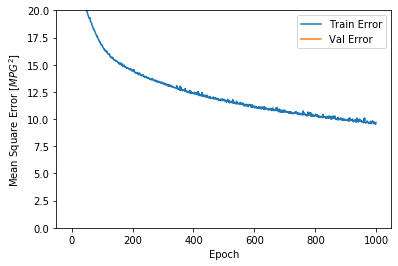

In [11]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


In [12]:
model = build_model()

In [13]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
..........................

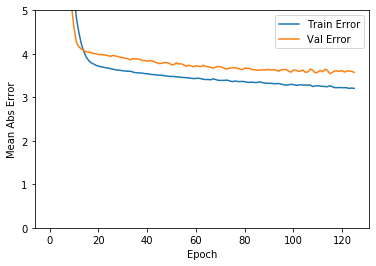

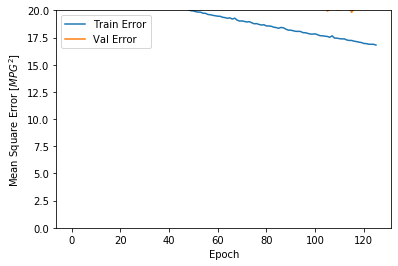

In [14]:
plot_history(history)

In [15]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Final Position".format(mae))


Testing set Mean Abs Error:  3.26 Final Position


In [16]:
test_predictions = model.predict(normed_test_data).flatten()


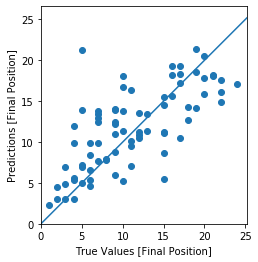

In [17]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Final Position]')
plt.ylabel('Predictions [Final Position]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
